In [1]:
import sys; sys.path.append('../src/playground_jax')
from time import time

from jax import numpy as jnp, random, nn, tree_util
from jax import grad, value_and_grad, vmap
from jaxtyping import Array, Float, Int, PyTree
import equinox as eqx
import optax
import matplotlib.pyplot as plt

from models_equinox import *

Goal: fit a scalar real-valued funciton
$ f: D \subset \mathbb{R} \rightarrow \mathbb{R}$

1. Generate training data

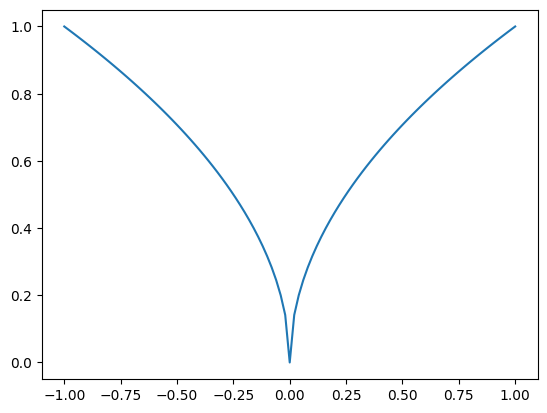

In [2]:
N = 101
x = jnp.expand_dims(jnp.linspace(-1, 1, N), axis=-1)
y = jnp.sqrt(jnp.abs(x))
#y = x**2
fig, ax = plt.subplots()
ax.plot(x, y)

2. build a model

In [32]:
# set a random key
key = random.PRNGKey(1)

# Generate random data for input
d_in, d_hiddens, d_out = 1, [32, 16, 8], 1

#model = Linear(d_in, d_out, key=key)
model = MLP(d_in, d_out, d_hiddens, activation=nn.tanh, final_activation=lambda x: x, key=key)
#model = MLP_4layers(d_in, d_out, d_hiddens, key)

In [33]:
def loss_fn(model, x, y):
    pred_y = vmap(model, in_axes=0, out_axes=0)(x)
    return jnp.mean((y - pred_y) ** 2)

4. Choose optimizer

In [34]:
lr = 1e-3
opt = optax.adam(learning_rate=lr)
opt_state = opt.init(eqx.filter(model, eqx.is_array))

5. Update function

In [35]:
@eqx.filter_jit
def make_step(model, x: Array, y: Array, opt_state: PyTree):
    
    # compute gradients and loss value
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)

    # optimizer upate
    updates, opt_state = opt.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

6. Train

In [36]:
n_iter = int(1e4)
log_period_iter = int(1e3)
for i in range(n_iter):
    t0 = time()
    loss, model, opt_state = make_step(model, x, y, opt_state)
    t1 = time()
    if i % log_period_iter  == 0: 
        print('it: {:d}, loss: {:.3e}, time: {:.4f}s'.format(i, loss, t1-t0))

it: 0, loss: 6.866e-01, time: 0.1926s
it: 1000, loss: 2.770e-03, time: 0.0003s
it: 2000, loss: 6.083e-04, time: 0.0003s
it: 3000, loss: 3.580e-04, time: 0.0003s
it: 4000, loss: 2.799e-04, time: 0.0003s
it: 5000, loss: 1.775e-04, time: 0.0003s
it: 6000, loss: 1.162e-04, time: 0.0003s
it: 7000, loss: 8.808e-05, time: 0.0003s
it: 8000, loss: 6.639e-05, time: 0.0003s
it: 9000, loss: 4.983e-05, time: 0.0003s


7. Evaluate results

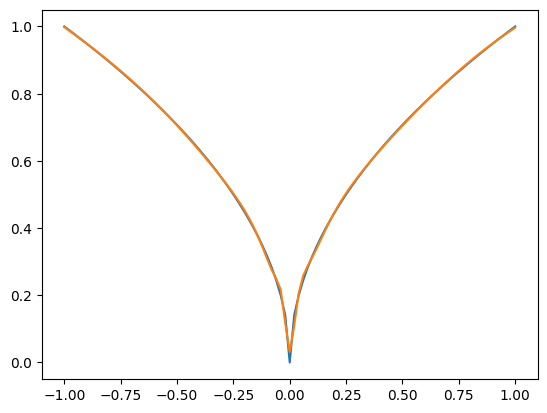

In [37]:
y_pred = vmap(model)(x)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, y_pred)